# **Centralized Training with Decentralized Execution**
**Presented by: Yuval Hoffman, Gil Gur Arieh**

**July 2023**

Tutorial objectives:


1.   Learn the motivation and definition for Centralized Training with Decentralized execution.
2.   Demonstrate the general idea using simple agents in the (simplified) CityLearn environment.
3.   Have fun!


Sources:
*  Book: "Multi-Agent Reinforcement Learning:
Foundations and Modern Approaches", (Albrecht, Christianos, Schäfer), 2023
*  Paper: "Benchmarking Multi-Agent Deep Reinforcement Learning
Algorithms on a Building Energy Demand Coordination Task", Dhamankar et. al., 2020
*  Paper: "Counterfactual Multi-Agent Policy Gradients", Foerster et. al., 2017
---



##Centralized Training with Decentralized execution - what and why?

For single-agent RL, one of the fundamental algorithms we encountered was Q-learning, which has a notable drawback of needing comprehensive knowledge of states and actions for every possible state/action pair in order to learn the system.

Consequently, we have seen some approaches to address this problem, including but not limited to:


*   Deep Neural Networks (NN) - to estimate the Value function or Q-value.
*   Policy Gradient - the REINFORCE algorithm.
*   Actor-Critic methods.


When considering multi-agent settings, We have seen two main paradigms to handle scenarios involving multiple agents:
* Centralized Training and Execution
* Independent Learning

In centralized training and execution, we consider joint observations, joint actions and a joint **scalar** reward. The learning process is performed using one of the single-agent methods we have already seen, and outputs a joint policy (from joint observations to joint actions). This paradigm utilizes the shared information and converges to a joint-policy which optimizes the joint reward. Centralized learning and execution is not always feasible or applicable for multiple reasons:
*  The joint reward for all agents must be transformed into a single scalar reward, which is inapplicable to some settings.
*  The central policy is learnt over an (exponentially) large action space.
*  Agents might be physically or virtually disturbed entities which might **limit communication**.


The second paradigm we covered is decentralized (independent) training and execution. Here, the training of agent policies as well as the policies themselves are fully decentralized. They do not rely on shared information and do not require constant communication. While they are more generally applicable and relatively easier to implement, they impose some problems:
*  Agents do not (necessarily) leverage all available information which can lead to non optimal policies.
*  Training is highly affected by non-stationarity caused by modelling other agents as a part of the environment (recall "Theory of Mind" in the IPOMDP guest lecture by Nitay Alon).

The comparison is summarized in the following graphic:

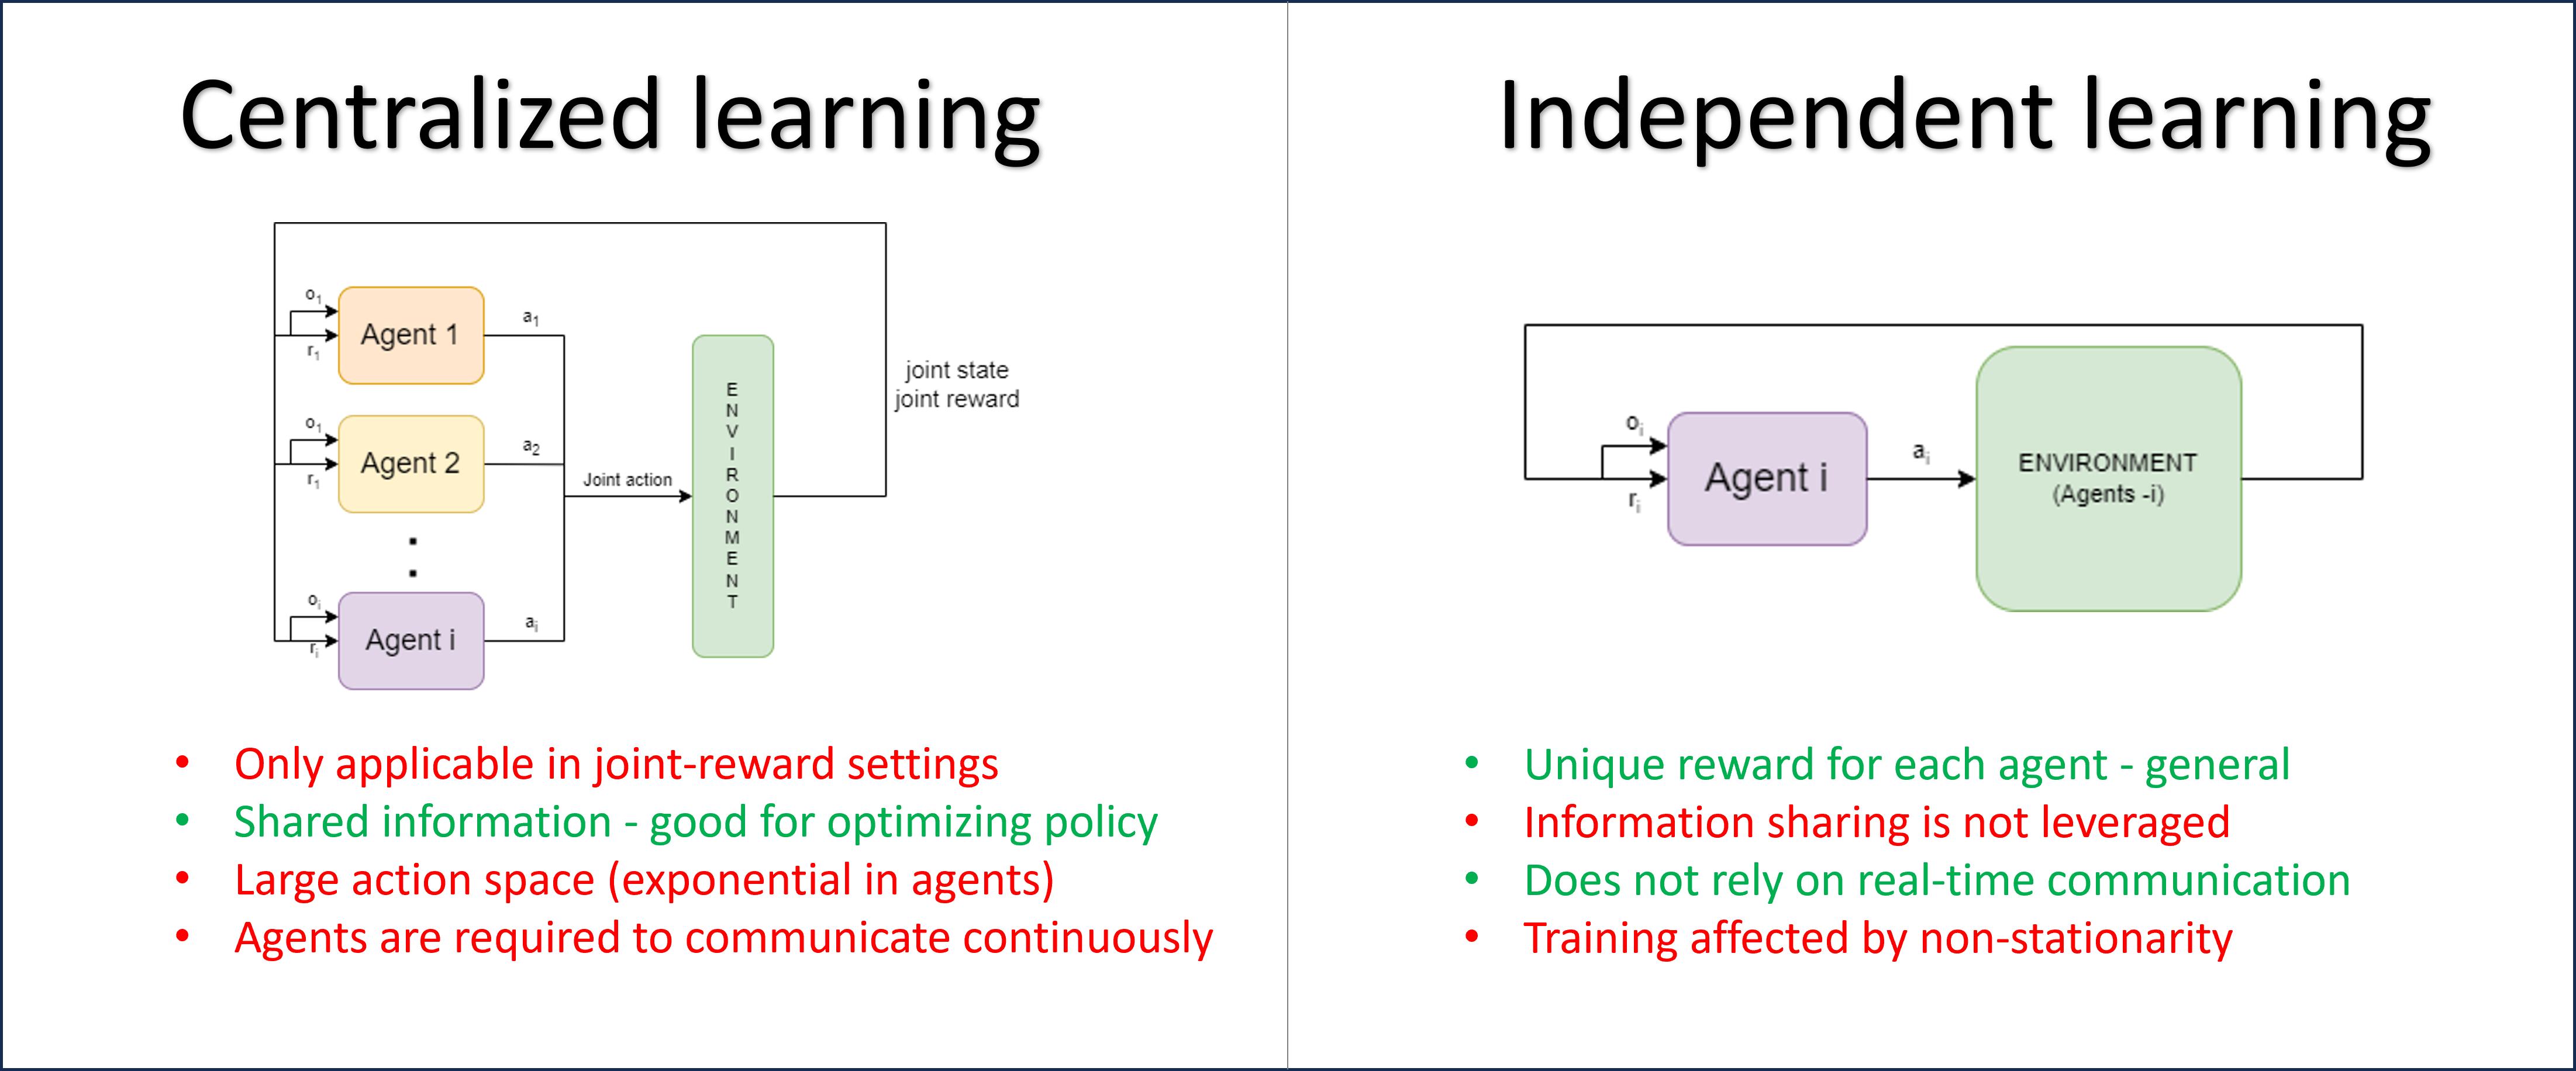

###Discussion: Which of the Paradigms should we use for -

1. Amazon warehouse robots (https://www.youtube.com/watch?v=YSrnV0wZywU)?
2. Financial markets?
3. Autonomous vehicles (cars on the road? parking lots? trains?)

###Centralized Training with Decentralized Execution

To solve some of the limiations mentioned above, a third paradigm is introduced: Central Training with Decentralized (independent) Execution (CTDE/ CTIE). The  concept uses centralized training to train agent policies, while the policies are designed for decentralized execution. This way, the shared information is used during the training stage, in which independent agent policies are trained using the available information, but the policies themselves require the agent's local observations to select actions. In that manner, the training part is different than in the fully centralized paradigm, as the decentralized execution requires training of multiple, independent policies.

In other words, the method trains multiple single-agent policies which map local agent observations to single-agent actions (as in independent learning), but the learning process utilizes shared information.

There are many possible algorithms that utilize this paradigm, which depend heavily on the setting and the problem at hand. An example of such implementation can be seen in the paper by Foerster et. al., and an expansion of this algorithm can be seen in the paper by Dhamankar et. al. .

The main novel challenge in this paradigm is how to model other agents in the single-agent policies (e.g. sub-intentional agents/DOM(0)/DOM(1), etc.).

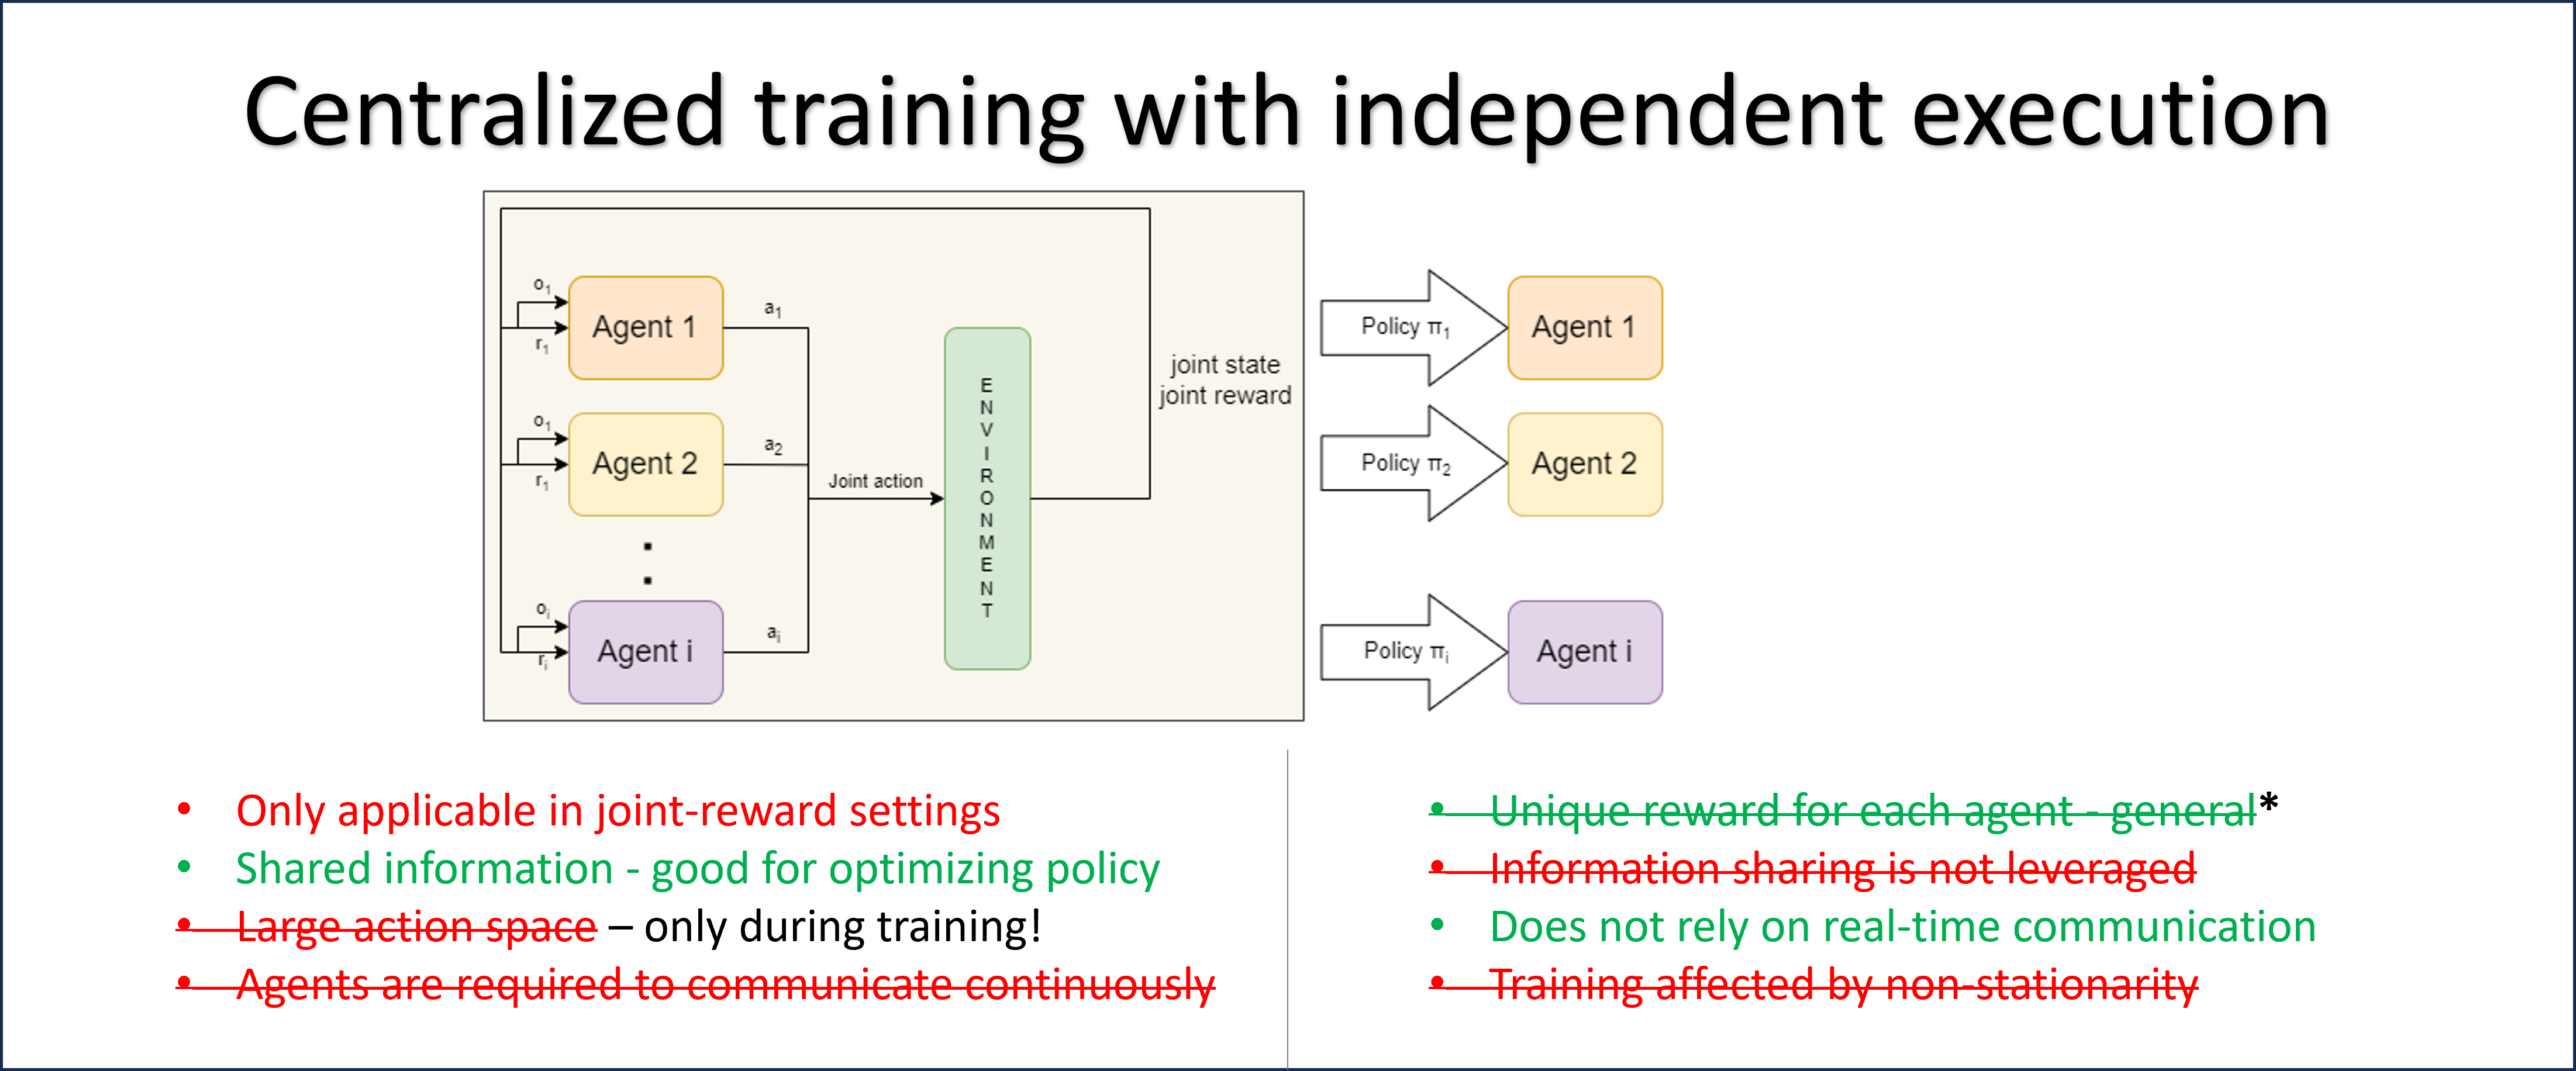

## Demonstration: CityLearn



To demonstrate a simple, educational CTDE algorithm, we use the CityLearn environment. we consider the following simplified setting:
1. 2 buildings (2 agents)
2. The action space for each building is -1/0/1 (discharge/noop/charge)
3. The observation space for each building is a tuple consisting 2 scalars: (current battery status (0/1), hour).
4. The joint reward function is the following:

\begin{align}
\bar{R} = \sum_{agent=1}^n min(-e_i, 0)
\end{align}

Where $e_i$ is the net energy consuption for the i-th agent (building), and it can be evaluated using methods implemented in the environment.



### Loading the environment (we've already seen this part)

In [1]:
!pip install -q CityLearn # the -q argument is for not printing the installation process to the screen.

                          # please ignore (if occurs) the following installation error "ERROR: pip's dependency resolver..."
                          # which is a results of torch version being uncompatible with colab,
                          # as long as we do not use PyTorch (in ample, for Reinforcement Learning) you
                          # shouldn't be concerned abount it.ex


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 47.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 1.3.5 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.12.0

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import datetime
import matplotlib.dates as mdates

from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import RewardFunction

Loading data

In [3]:
dataset_name = 'citylearn_challenge_2022_phase_1'
number_of_building = 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We initialize the CityLearn environment with the data set.

In [4]:
env = CityLearnEnv(dataset_name)

**The observation and action space**

For convenience, we recall the structure of the observation space (we will only use part of it):

In [5]:
obs_elements = []
ii = 0
for item in env.schema['observations'].items():
  if item[1]['active'] == True:
    txt = [str(ii), str(item[0]), str(ii-28)]
    print(txt)
    obs_elements.append(item[0])
    ii = ii+1

['0', 'month', '-28']
['1', 'day_type', '-27']
['2', 'hour', '-26']
['3', 'outdoor_dry_bulb_temperature', '-25']
['4', 'outdoor_dry_bulb_temperature_predicted_6h', '-24']
['5', 'outdoor_dry_bulb_temperature_predicted_12h', '-23']
['6', 'outdoor_dry_bulb_temperature_predicted_24h', '-22']
['7', 'outdoor_relative_humidity', '-21']
['8', 'outdoor_relative_humidity_predicted_6h', '-20']
['9', 'outdoor_relative_humidity_predicted_12h', '-19']
['10', 'outdoor_relative_humidity_predicted_24h', '-18']
['11', 'diffuse_solar_irradiance', '-17']
['12', 'diffuse_solar_irradiance_predicted_6h', '-16']
['13', 'diffuse_solar_irradiance_predicted_12h', '-15']
['14', 'diffuse_solar_irradiance_predicted_24h', '-14']
['15', 'direct_solar_irradiance', '-13']
['16', 'direct_solar_irradiance_predicted_6h', '-12']
['17', 'direct_solar_irradiance_predicted_12h', '-11']
['18', 'direct_solar_irradiance_predicted_24h', '-10']
['19', 'carbon_intensity', '-9']
['20', 'non_shiftable_load', '-8']
['21', 'solar_gener

## Training stage - Centralized Q-Learning algorithm

In the training stage, we use joint observations and joint actions, as we've already seen in Centralized-training-and-execution algorithms. For this relatively simple setting with small observation and action spaces, we choose centralized Q-learning for the training stage.

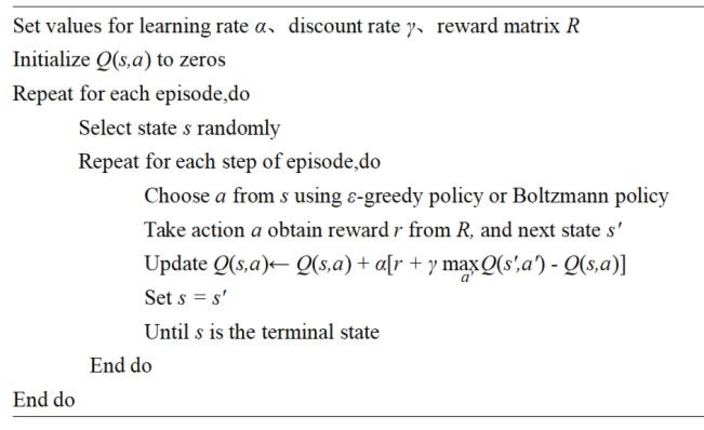

In [6]:
# reset the environment
joint_observation = env.reset()

alpha = 0.1  # Q-table update parameter

n_steps = 24*7      # setting up the number of steps of the learning stage (hours in the simulation, i.e. 24 is a whole single day)


The following block **initializes the Q-table** for this problem.

The joint-observation is a tuple of single-agent local observations:
 ```
((battery_state_agent_0, hour),(battery_state_agent_1,hour))
```
where ```battery_state_agent_i``` is either 0 or 1 (empty or full). The action space is a tuple of single-agent local actions:

```
([action_agent_0],[action_agent_1])
```
Where ```action_state_agent_i``` is either -1.0, 0.0 or 1.0 (discharge, noop or charge).




In [7]:
# Generate hour_vector from 1 to 24
hour_vector = np.arange(1, 25, 1)

# Generate all possible states - hours from 1 to 24, battery empty or full for each building:
state_vector_multi = []
for hour in hour_vector:
  bat_empty = (0, hour)
  bat_full = (1, hour)
  state_vector_multi.append((bat_empty, bat_empty))
  state_vector_multi.append((bat_empty, bat_full))
  state_vector_multi.append((bat_full, bat_empty))
  state_vector_multi.append((bat_full, bat_full))
print(state_vector_multi)

# Define the possible actions:
elements = ([-1.0], [0.0], [1.0])

# Generate action_vector with all combinations of the specified number of buildings and elements
action_vector = list(product(elements, repeat=number_of_building))
print(action_vector)

# Create Q_table with zeros, where the number of rows is the length of state_tuple_vector and the number of columns is the length of action_vector
Q_table = np.zeros((len(state_vector_multi), len(action_vector)))
# print(Q_table)

[((0, 1), (0, 1)), ((0, 1), (1, 1)), ((1, 1), (0, 1)), ((1, 1), (1, 1)), ((0, 2), (0, 2)), ((0, 2), (1, 2)), ((1, 2), (0, 2)), ((1, 2), (1, 2)), ((0, 3), (0, 3)), ((0, 3), (1, 3)), ((1, 3), (0, 3)), ((1, 3), (1, 3)), ((0, 4), (0, 4)), ((0, 4), (1, 4)), ((1, 4), (0, 4)), ((1, 4), (1, 4)), ((0, 5), (0, 5)), ((0, 5), (1, 5)), ((1, 5), (0, 5)), ((1, 5), (1, 5)), ((0, 6), (0, 6)), ((0, 6), (1, 6)), ((1, 6), (0, 6)), ((1, 6), (1, 6)), ((0, 7), (0, 7)), ((0, 7), (1, 7)), ((1, 7), (0, 7)), ((1, 7), (1, 7)), ((0, 8), (0, 8)), ((0, 8), (1, 8)), ((1, 8), (0, 8)), ((1, 8), (1, 8)), ((0, 9), (0, 9)), ((0, 9), (1, 9)), ((1, 9), (0, 9)), ((1, 9), (1, 9)), ((0, 10), (0, 10)), ((0, 10), (1, 10)), ((1, 10), (0, 10)), ((1, 10), (1, 10)), ((0, 11), (0, 11)), ((0, 11), (1, 11)), ((1, 11), (0, 11)), ((1, 11), (1, 11)), ((0, 12), (0, 12)), ((0, 12), (1, 12)), ((1, 12), (0, 12)), ((1, 12), (1, 12)), ((0, 13), (0, 13)), ((0, 13), (1, 13)), ((1, 13), (0, 13)), ((1, 13), (1, 13)), ((0, 14), (0, 14)), ((0, 14), (

The current Q-table with joint states and actions looks like this:

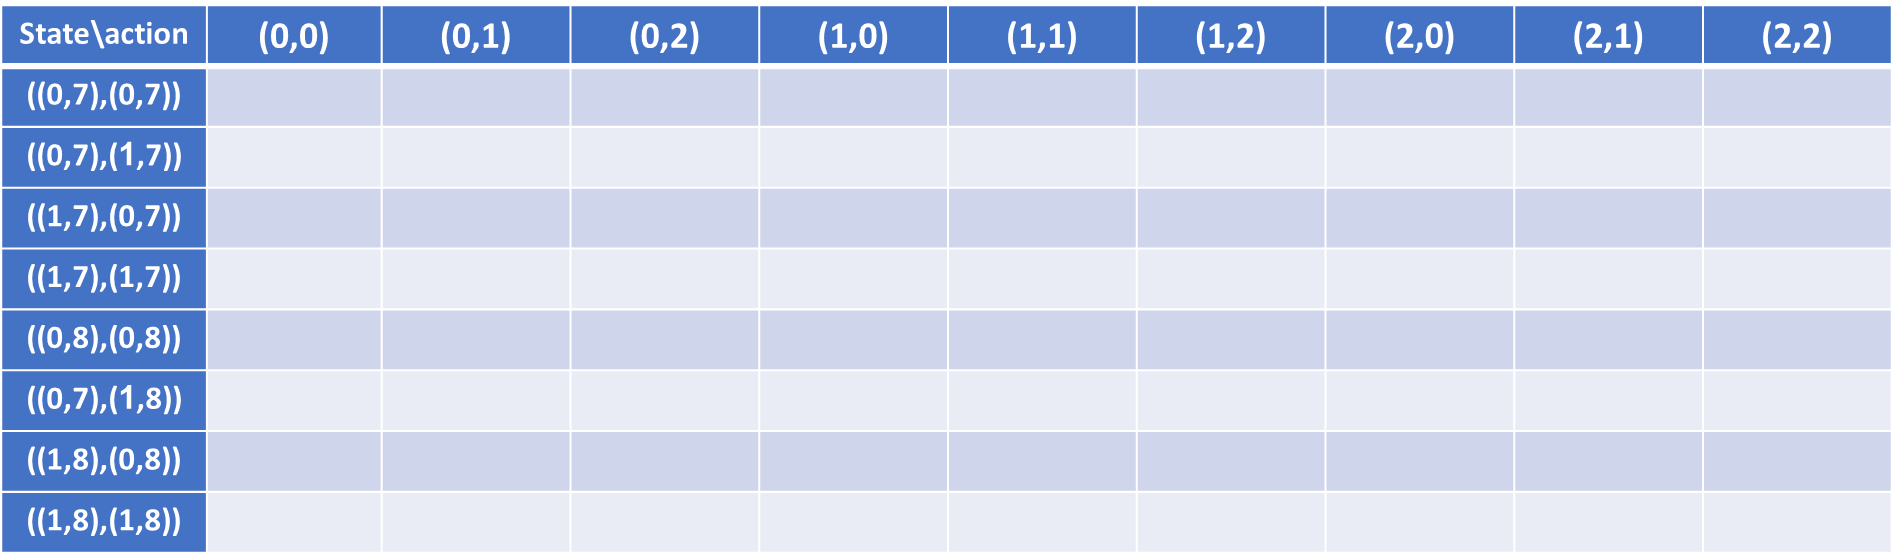

### Some auxiliary functions

In [8]:
def Get_obs_return_reward(joint_observation):
  '''
  For a 2-building setting, this function takes a joint observation and returns the joint reward (sum of local rewards), as defined above.
  '''
  # This function works only for 2-building setting!
  e_building0 = joint_observation[0][-5]
  e_building1 = joint_observation[1][-5]

  e_consumpt = [e_building0, e_building1]
  reward = RewardFunction(env, agent_count=2, electricity_consumption=e_consumpt)  # built-in function which returns a vector of rewards for all agents
  return np.sum(reward.calculate())


In [9]:
def Get_State_Return_Action(Q_table, state, epsilon):
  '''
  This function is an epsilon-greedy function for joint-Q-learning:
  with probability epsilon it returns a random action. Otherwise, chooses a value which optimizes Q.
  '''
  row_indices = state_vector_multi.index(state)

  if random.random() < epsilon: #Exploration - randomize action
    action_idx = random.randint(0, len(Q_table[0,:])-1)
  else: #Exploitation - maximize Q value
    action_idx = np.argmax(Q_table[row_indices,:])

  action = list(action_vector[action_idx])

  for ii in np.arange(number_of_building,5):
      action.append([0.0])

  return action, action_idx

In [10]:
def Get_Obs_Return_State(joint_observation, building_ids=[0, 1]):
  '''
  input: joint observation from the environment 'step',
          building_ids: list of size 'number_of_building' consisting building ids
  output: tuple consisting of: battery full (0 or 1) and current hour
  '''
  temp_list = []
  for ii in building_ids:
    # Create a list with a tuple (storage, hour). the storage quantiz to two stage '0' and '1'
    storage = 1 if joint_observation[ii][22] > 0.5 else 0
    temp_list.append((storage,joint_observation[ii][2]))

  return tuple(temp_list)

### Simulation

In [11]:
def Simulate_the_env(n_times, Q_table):

  for ii in np.arange(0,n_times):
    # run through the environment:
    # restart env and the data to plot (but NOT the Q-table)
    joint_observation = env.reset()
    all_observation = np.zeros((n_steps,5,len(joint_observation[1])))
    specific_datetime = []


    epsilon_vector = np.linspace(1, 0.05, n_steps)
    for iteration in range(n_steps):
      epsilon = epsilon_vector[iteration]
      # Find the current state
      state = Get_Obs_Return_State(joint_observation)

      # sample random actions for all buildings
      joint_action, action_idx = Get_State_Return_Action(Q_table, state, epsilon)
      # print(f"state: {state}")
      # print(f"joint action: {joint_action}")
      # print(f"state id: {state_vector_multi.index(state)}")

      # step the environmnet
      next_joint_observation, reward, info, done = env.step(joint_action)

      # collect the data
      all_observation[iteration,:,:] = np.array(next_joint_observation)
      specific_datetime.append(datetime.datetime(2021, next_joint_observation[0][0], next_joint_observation[0][1], next_joint_observation[0][2]-1, 0, 0))

      #The real reward obtained from the reward function.
      reward = Get_obs_return_reward(next_joint_observation)
      # print(f"reward: {reward}")

      #Update the Q-value table and state.
      next_state = Get_Obs_Return_State(next_joint_observation)
      next_state_idx = state_vector_multi.index(next_state)
      next_action, next_action_idx = Get_State_Return_Action(Q_table, next_state, epsilon)
      Q_table[state_vector_multi.index(state),action_idx] = Q_table[state_vector_multi.index(state),action_idx] + alpha*(reward + Q_table[next_state_idx,next_action_idx] - Q_table[state_vector_multi.index(state),action_idx])
      joint_observation = next_joint_observation
    return Q_table, all_observation, specific_datetime


In [29]:
Q_table, all_observation, specific_datetime = Simulate_the_env(1000, Q_table)

```
The following function and code block are supplementary for self-check of convergence and are not required to run the algorithm:
```


In [13]:
def Plot_Obser(specific_datetime,all_observation,obs_idx, building_idx = 0):
  ''' plotting the data collected'''
  fig, ax = plt.subplots(1, 1, figsize=(12, 3))

  # Format the x-axis
  ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Set the major tick every 12 hours
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))  # Format the tick labels as 'month-day hour:minute'

  # Rotate the tick labels for better visibility (optional)
  plt.xticks(rotation=45)

  # Set labels and title
  ax.set_title(f"Data collected from observation {obs_elements[obs_idx]} for building- {building_idx}")
  ax.plot(specific_datetime, all_observation[:,building_idx ,obs_idx], '-o')
  ax.set_xlabel("Time")
  ax.set_ylabel(obs_elements[obs_idx])
  ax.grid()
  #ax.legend()

  # Display the plot
  #plt.show(block = False)
  return fig, ax


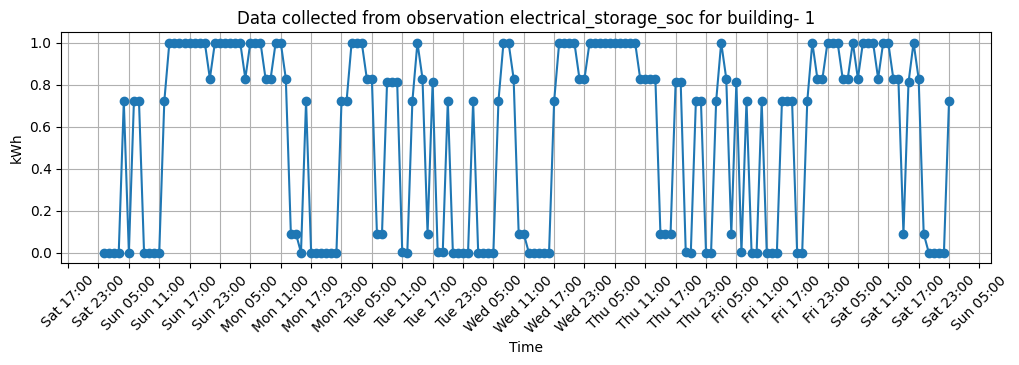

In [30]:
fig, ax = Plot_Obser(specific_datetime,all_observation,22, 1)
ax.set_ylabel("kWh")
plt.show()

## Decentralized Execution

After training and filling the Q-table, we now must extract single-agent policies which map local single-agent observations to local single-agent actions. In our case, for each agent, each observation/action pair corresponds to several Q-table values, as seen in the graphic below:

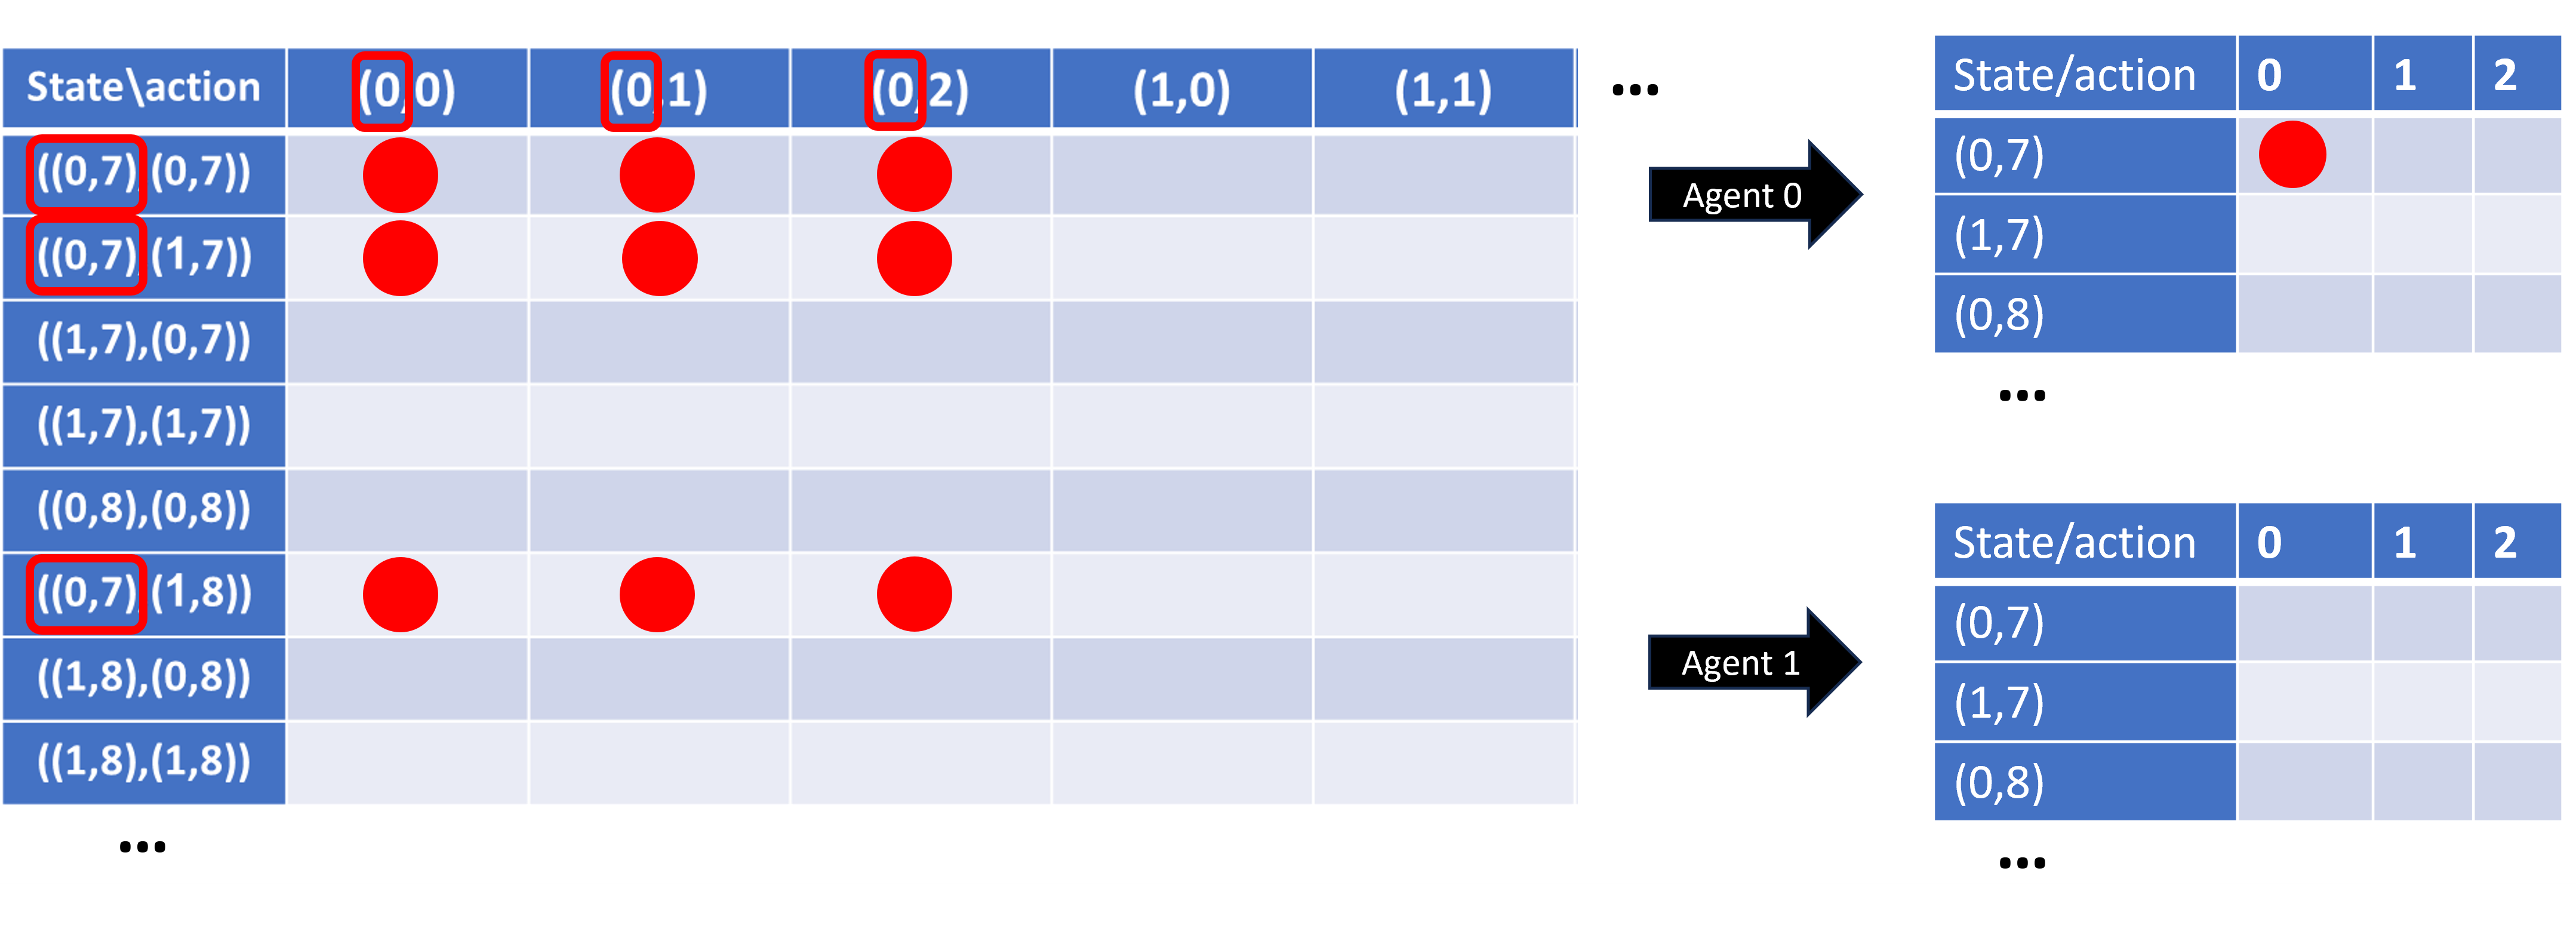

There are many ways to aggregate the learned data into a single-agent policies, the selection of which is dependent on the way we want to model how each agent sees the other agents. Examples of approaches:

1. Naive averaging - simply averaging all the appropriate Q-values into a single-agent Q-value for the local state-action pair. This approach is easy to compute but does not utilize effectively the learning process.
2. Weighted averaging - average the appropriate Q-values, adding weights which correspond to the number of times the joint state/action pair was visited during the training stage (e.g. If at 7 PM the other agent charges the battery 9/10 times, the joint-Q-value corresponding with this action would be weighted by 9 times the values for the other actions).
3. Modelling other agents as stochastic environmental features (which can or cannot be observed) - This complicates the algorithm...

Generally, the more we account for other agents in our single-policies, the closer we become to a centralized solution. In our code, we use naive averaging - simply averaging over all corresponding joint-state-action Q-values.



### Extracting agent policies

In [17]:
def extract_agent_policy(building_id, joint_Q_table):
  '''
  Inputs: building_id - 0 or 1
          joint_Q_table - the large learnt Q table
  Outputs: policy - dictionary mapping from observation to action
  This function takes the large Q-table and extracts a single-agent policy,
  generalizing for each battery-state/hour tuple state.
  '''
  agent_policy = {}
  states = []
  actions = [[-1.0], [0.0], [1.0]]

  # Create lists consisting all possible states and actions for a single agent
  hour_vector = np.arange(1, 25, 1)
  for hour in hour_vector:
    states.append((0, hour))
    states.append((1, hour))

  # Create a new Q-table for the single agent, averaging Q values for repeating states and actions
  Q_table_agent = np.zeros((len(states), len(actions)))
  for state_index in range(len(states)):
    for action_index in range(len(actions)):
      state = states[state_index]
      action = actions[action_index]
      Q_values = []
      for joint_state_index in range(len(state_vector_multi)):
        for joint_action_index in range(len(action_vector)):
          joint_state = state_vector_multi[joint_state_index]
          joint_action = action_vector[joint_action_index]
          if joint_state[building_id] == state and joint_action[building_id] == action:
            Q_values.append(joint_Q_table[joint_state_index][joint_action_index])
      if Q_values:
        Q_table_agent[state_index][action_index] = sum(Q_values)/len(Q_values)
  # Extract the agent policy using argmax
  for state_index in range(len(states)):
    state = states[state_index]
    best_action_idx = np.argmax(Q_table_agent[state_index, :])
    best_action = actions[best_action_idx]
    agent_policy[state] = best_action
  return agent_policy

In [18]:
# Extracting single-agent policies (dictionaries) from Q-table:
policy_building0 = extract_agent_policy(0, Q_table)
policy_building1 = extract_agent_policy(1, Q_table)
print(policy_building0)

{(0, 1): [0.0], (1, 1): [0.0], (0, 2): [0.0], (1, 2): [-1.0], (0, 3): [0.0], (1, 3): [1.0], (0, 4): [0.0], (1, 4): [0.0], (0, 5): [1.0], (1, 5): [0.0], (0, 6): [0.0], (1, 6): [0.0], (0, 7): [1.0], (1, 7): [0.0], (0, 8): [0.0], (1, 8): [1.0], (0, 9): [-1.0], (1, 9): [-1.0], (0, 10): [0.0], (1, 10): [1.0], (0, 11): [0.0], (1, 11): [1.0], (0, 12): [0.0], (1, 12): [0.0], (0, 13): [1.0], (1, 13): [-1.0], (0, 14): [0.0], (1, 14): [0.0], (0, 15): [0.0], (1, 15): [0.0], (0, 16): [1.0], (1, 16): [-1.0], (0, 17): [0.0], (1, 17): [0.0], (0, 18): [1.0], (1, 18): [1.0], (0, 19): [0.0], (1, 19): [-1.0], (0, 20): [1.0], (1, 20): [-1.0], (0, 21): [0.0], (1, 21): [0.0], (0, 22): [1.0], (1, 22): [-1.0], (0, 23): [1.0], (1, 23): [-1.0], (0, 24): [0.0], (1, 24): [1.0]}


### Evaluating the agents - running the environment

In [19]:
# We evaluate using the same environment, but from the applying the policy to different buildings (2 and 3)
test_env = CityLearnEnv(dataset_name)

In [20]:
# Initializing
# TODO STUDENTS - choose which data to extract:
no_of_steps = 7*24
## YOUR CODE HERE ##
all_observation = np.zeros((no_of_steps,5,len(joint_observation[1])))
specific_datetime = []
## END OF YOUR CODE ##
joint_observation = test_env.reset()
building_ids = [2, 3]

for timestep in range(no_of_steps):
  state = Get_Obs_Return_State(joint_observation, building_ids)
  actions = [[0.0],[0.0]]                       #building '0', and '1'.
  actions.append(policy_building0[state[0]]) #building '2'.
  actions.append(policy_building1[state[1]]) #building '3'.
  actions.append([0.0])                      #building '4'.
  next_joint_observation, reward, info, done = test_env.step(actions)
  ## YOUR CODE HERE ##
  all_observation[timestep,:,:] = np.array(next_joint_observation)
  specific_datetime.append(datetime.datetime(2021, next_joint_observation[0][0], next_joint_observation[0][1], next_joint_observation[0][2]-1, 0, 0))

  ## END OF YOUR CODE ##
  joint_observation = next_joint_observation

## TODOs


### TODO 1 - Evaluate the agents performance

Change the code under "evaluating the agents" (adding your own code in the dedicated spaces) so that the relevant data to evaluate agent performance is extracted. Then, write your code below to plot an evaluation of the agent performance.


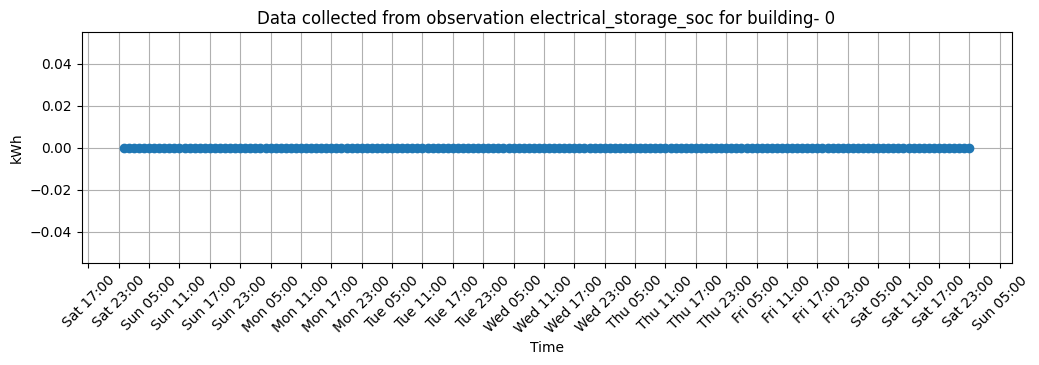

In [21]:
## TODO1 -  YOUR CODE HERE ##
fig, ax = Plot_Obser(specific_datetime,all_observation,22, 0)
ax.set_ylabel("kWh")
plt.show()

### TODO 2 - Evaluate the consistency of the Training stage

We want to make sure our learning stage is consistent, that is, if we train it again using the same data we get generally similar policies.
Write a code that trains the agents twice (or more times if you like), using the same data, and compare the resulted policies.

In [33]:
Q_table_empty = np.zeros((len(state_vector_multi), len(action_vector)))
## TODO 2 - YOUR CODE HERE ##
# HINT: use the already-defined functions 'Simulate_the_env', 'extract_agent_policy.
# Then, train several 2-building agent pairs, and count for how many states we get the same action

# 10^4
Q_table, all_observation, specific_datetime = Simulate_the_env(10**4, Q_table_empty)
agent_policy_0 = extract_agent_policy(0, Q_table)

# 2*10^4
Q_table, all_observation, specific_datetime = Simulate_the_env(2*10**4, Q_table_empty)
agent_policy_1 = extract_agent_policy(0, Q_table)

print(agent_policy_1)
count = 0
for key, value in agent_policy_0.items():
        if key in agent_policy_1 and agent_policy_1[key] == value:
            count += 1

print(count/len(agent_policy_0.items()))

{(0, 1): [0.0], (1, 1): [0.0], (0, 2): [1.0], (1, 2): [0.0], (0, 3): [-1.0], (1, 3): [1.0], (0, 4): [0.0], (1, 4): [0.0], (0, 5): [0.0], (1, 5): [0.0], (0, 6): [0.0], (1, 6): [0.0], (0, 7): [1.0], (1, 7): [-1.0], (0, 8): [0.0], (1, 8): [1.0], (0, 9): [0.0], (1, 9): [-1.0], (0, 10): [0.0], (1, 10): [0.0], (0, 11): [0.0], (1, 11): [0.0], (0, 12): [0.0], (1, 12): [0.0], (0, 13): [0.0], (1, 13): [0.0], (0, 14): [1.0], (1, 14): [1.0], (0, 15): [1.0], (1, 15): [0.0], (0, 16): [1.0], (1, 16): [0.0], (0, 17): [0.0], (1, 17): [1.0], (0, 18): [1.0], (1, 18): [-1.0], (0, 19): [0.0], (1, 19): [1.0], (0, 20): [0.0], (1, 20): [1.0], (0, 21): [1.0], (1, 21): [1.0], (0, 22): [1.0], (1, 22): [-1.0], (0, 23): [1.0], (1, 23): [0.0], (0, 24): [0.0], (1, 24): [1.0]}
0.6458333333333334


### TODO 3 - Smarter single-agent policy extraction.
In this demonstration, we've implemented a naive-averaging approach to extract single-agent policy. Based on the provided code, write a similar function which extracts single-agent policy using **weighted averaging**.

In [71]:
def extract_agent_policy_weighted_averaging(building_id, joint_Q_table, all_observation):
  '''
  Inputs: building_id - 0 or 1
          joint_Q_table - the large learnt Q table
          all_observation - the last simulation observation (for all state)
  Outputs: policy - dictionary mapping from observation to action
  This function takes the large Q-table and extracts a single-agent policy,
  generalizing for each battery-state/hour tuple state.
  '''
  agent_policy = {}
  states = []
  actions = [[-1.0], [0.0], [1.0]]

  ### YOUR CODE HERE ###

  ## stage 1 - Calculate the number of time the agent was in the last simulation

  # Create lists consisting all possible states and actions for a single agent
  hour_vector = np.arange(1.0, 25.0, 1.0)
  for hour in hour_vector:
    states.append((0, hour))
    states.append((1, hour))

  count_sum = np.zeros(len(state_vector_multi))

  for ii in range(len(all_observation[:,0,0])):
    joint_observation = all_observation[ii,:,:]
    (state_0, state_1) = Get_Obs_Return_State(joint_observation, [0, 1])
    temp = (state_0, state_1)
    count_sum[state_vector_multi.index(temp)] += 1


  ## stage 2 - find all the double state where the state occure
  # Create a new Q-table for the single agent, averaging Q values for repeating states and actions
  Q_table_agent = np.zeros((len(states), len(actions)))
  for state_index in range(len(states)):
    derive_by = 0
    for action_index in range(len(actions)):
      state = states[state_index]
      action = actions[action_index]
      Q_values = []
      for joint_state_index in range(len(state_vector_multi)):
        for joint_action_index in range(len(action_vector)):
          joint_state = state_vector_multi[joint_state_index]
          joint_action = action_vector[joint_action_index]
          if joint_state[building_id] == state and joint_action[building_id] == action:
            Q_values.append(count_sum[joint_state_index]*joint_Q_table[joint_state_index][joint_action_index])
            derive_by = derive_by + count_sum[joint_state_index]
      if Q_values:
        if derive_by != 0:
          Q_table_agent[state_index][action_index] = sum(Q_values)/derive_by
        else:
          Q_table_agent[state_index][action_index] = sum(Q_values)
  # Extract the agent policy using argmax
  for state_index in range(len(states)):
    state = states[state_index]
    best_action_idx = np.argmax(Q_table_agent[state_index, :])
    best_action = actions[best_action_idx]
    agent_policy[state] = best_action

  ### END OF YOUR CODE ###
  return agent_policy

extract_agent_policy_weighted_averaging(0, Q_table, all_observation)

2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
2.0
4.0
6.0
7.0
8.0
9.0
11.0
13.0
15.0
16.0
17.0
18.0
20.0
22.0
24.0
25.0
26.0
27.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
3.0
6.0
9.0
9.0
9.0
9.0
12.0
15.0
18.0
18.0
18.0
18.0
21.0
24.0
27.0
27.0
27.0
27.0
3.0
6.0
9.0
11.0
13.0
15.0
18.0
21.0
24.0
26.0
28.0
30.0
33.0
36.0
39.0
41.0
43.0
45.0
2.0
4.0
6.0
6.0
6.0
6.0
8.0
10.0
12.0
12.0
12.0
12.0
14.0
16.0
18.0
18.0
18.0
18.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
3.0
6.0
9.0
9.0
9.0
9.0
12.0
15.0
18.0
18.0
18.0
18.0
21.0
24.0
27.0
27.0
27.0
27.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
1.0
2.0
3.0
5.0
7.0
9.0
10.0
11.0
12.0
14.0
16.0
18.0
19.0
20.0
21.0
23.0
25.0
27.0
3.0
6.0
9.0
11.0
13.0
15.0
18.0
21.0
24.0
26.0
28.0
30.0
33.0
36.0
39.0
41.0
43.0
45.0
0.0
0.0
0.0
2.0
4.0
6.0
6.0
6.0
6.0
8.0
10.0
12.0
12.0
12.0
12.

{(0, 1.0): [0.0],
 (1, 1.0): [0.0],
 (0, 2.0): [1.0],
 (1, 2.0): [0.0],
 (0, 3.0): [1.0],
 (1, 3.0): [0.0],
 (0, 4.0): [0.0],
 (1, 4.0): [0.0],
 (0, 5.0): [1.0],
 (1, 5.0): [1.0],
 (0, 6.0): [0.0],
 (1, 6.0): [0.0],
 (0, 7.0): [1.0],
 (1, 7.0): [-1.0],
 (0, 8.0): [1.0],
 (1, 8.0): [1.0],
 (0, 9.0): [0.0],
 (1, 9.0): [1.0],
 (0, 10.0): [0.0],
 (1, 10.0): [0.0],
 (0, 11.0): [0.0],
 (1, 11.0): [0.0],
 (0, 12.0): [0.0],
 (1, 12.0): [0.0],
 (0, 13.0): [0.0],
 (1, 13.0): [0.0],
 (0, 14.0): [1.0],
 (1, 14.0): [1.0],
 (0, 15.0): [1.0],
 (1, 15.0): [1.0],
 (0, 16.0): [1.0],
 (1, 16.0): [0.0],
 (0, 17.0): [0.0],
 (1, 17.0): [1.0],
 (0, 18.0): [1.0],
 (1, 18.0): [-1.0],
 (0, 19.0): [1.0],
 (1, 19.0): [1.0],
 (0, 20.0): [0.0],
 (1, 20.0): [1.0],
 (0, 21.0): [1.0],
 (1, 21.0): [-1.0],
 (0, 22.0): [1.0],
 (1, 22.0): [-1.0],
 (0, 23.0): [1.0],
 (1, 23.0): [0.0],
 (0, 24.0): [0.0],
 (1, 24.0): [1.0]}

### TODO 4 - Thinking about the project...

We've demonstrated a naive approach using Q-learning for a "degenerated" CityLearn environment. The general environment uses larger action and state spaces which can make Q-learning quite impractical. Read the relevant chapter in the book (which is in the course materials), and suggest a different approach for actualizing a CTDE algorithm, which better suits the CityLearn RL problem.

"A more sophisticated approach would be to use an Actor-Critic algorithm. In this approach, the Actor (decentralized) network only requires the local observation history. During training, the Critic network is centralized and responsible for estimating the quality of a state (Value, Q-Value, or Advantage function). At the same time, a decentralized critic is also learned to estimate the quality based on local observations only.